# Introduction + Set-up

Machine learning has a phenomenal range of application in the health sciences. This tutorial will go over the complete pipeline to build a model that can determine the dementia level of an Alzheimer's patient from their MRI image. This model achieves an a high ROC AUC score.

This tutorial highlights the ease of building a CNN using `tf.keras`. Additionally, TensorFlow 2.3 has new features, including easy data loading utilities that were previously not available in TensorFlow 2.2. We'll be seeing how easy data loading is with these additional features.

We'll be using a GPU accelerator for this NB.

In [67]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import kaggledatasets 
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import shutil
from PIL import Image
from glob import glob
from os.path import join
from sklearn.metrics import confusion_matrix, classification_report
import itertools
from sklearn.model_selection import ParameterGrid
from scikeras.wrappers import KerasClassifier 
from sklearn.model_selection import RandomizedSearchCV

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)


gpus = tf.config.list_physical_devices('GPU')                       #se the gpu
if gpus:
    print(f"Found {len(gpus)} GPU")
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
    
print(tf.__version__)


Number of replicas: 1
2.14.0


It's always a good idea to set constant variables instead of hard coding numbers into your code. It saves time later when you want to change certain parameters.

In [68]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [128, 128]
#EPOCHS = 15

# Data Loading

We'll be using a [Kaggle Alzheimer's dataset](https://www.kaggle.com/tourist55/alzheimers-dataset-4-class-of-images) for our tutorial. `tf.keras` has a new preprocessing function that can easily load in images for a directory. In order for this function to work, the data has to be structured in a file directory format.

```
main_directory/
    class1/
        class1_images
    class2/
        class2_images
```

If you input the `main_directory` into the `tf.keras` function, it will figure out the rest!
In our case, the `train` directory is our main directory.

We are also specifying a 80:20 split for our training and validation datasets. To learn more about the importance of having a validation split, check out this [lesson](https://developers.google.com/machine-learning/crash-course/validation/another-partition) from Google's Machine Learning Crash Course.

In [69]:
# split and save dataset into train/val and test data
dataset_path = 'Dataset'
test_size=0.2
train_path = dataset_path+'/train' #folder doesn’t exist yet
test_path= dataset_path+'/test'
classes = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
print(classes)

if os.path.isdir(train_path):
    print('Dataset has already been splited and saved into train/val and test data.')
else:
    os.makedirs(train_path, exist_ok=True)
    os.makedirs(test_path, exist_ok=True)
    print(classes)

    for class_name in classes:
        print(class_name)
        class_path = os.path.join(dataset_path, class_name)
        train_class_path = os.path.join(train_path, class_name)
        test_class_path = os.path.join(test_path, class_name)

        # Get the list of files in the class
        files = os.listdir(class_path)
        os.makedirs(train_class_path, exist_ok=True)
        os.makedirs(test_class_path, exist_ok=True)

        # Divide the class dataset into training and test sets
        train_files, test_files = train_test_split(files, test_size=test_size, random_state=42)

        # Save the training files to the training folder
        for file in train_files:
            src_path = os.path.join(class_path, file)
            dst_path = os.path.join(train_path, class_name, file)
            shutil.copy(src_path, dst_path)

        # Save the test files to the test folder
        for file in test_files:
            src_path = os.path.join(class_path, file)
            dst_path = os.path.join(test_path, class_name, file)
            shutil.copy(src_path, dst_path)

# split train/val into train and val data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
Mild_Demented
Moderate_Demented
Non_Demented
Very_Mild_Demented
Found 5119 files belonging to 4 classes.
Using 4096 files for training.
Found 5119 files belonging to 4 classes.
Using 1023 files for validation.


We'll be renaming the class names and specifying the number of classes. In this case, we have 4 classes of dementia.

In [70]:

train_ds.class_names = classes
val_ds.class_name = classes

NUM_CLASSES = len(classes)

# Visualize the data

Now that our data has been easily loaded in, the next step is to visualize our images. This helps us understand what is being used as an input for our model. It also serves as a check to see if our images have been loaded in correctly.

Mild_Demented class has 716 samples
Moderate_Demented class has 51 samples
Non_Demented class has 2560 samples
Very_Mild_Demented class has 1792 samples


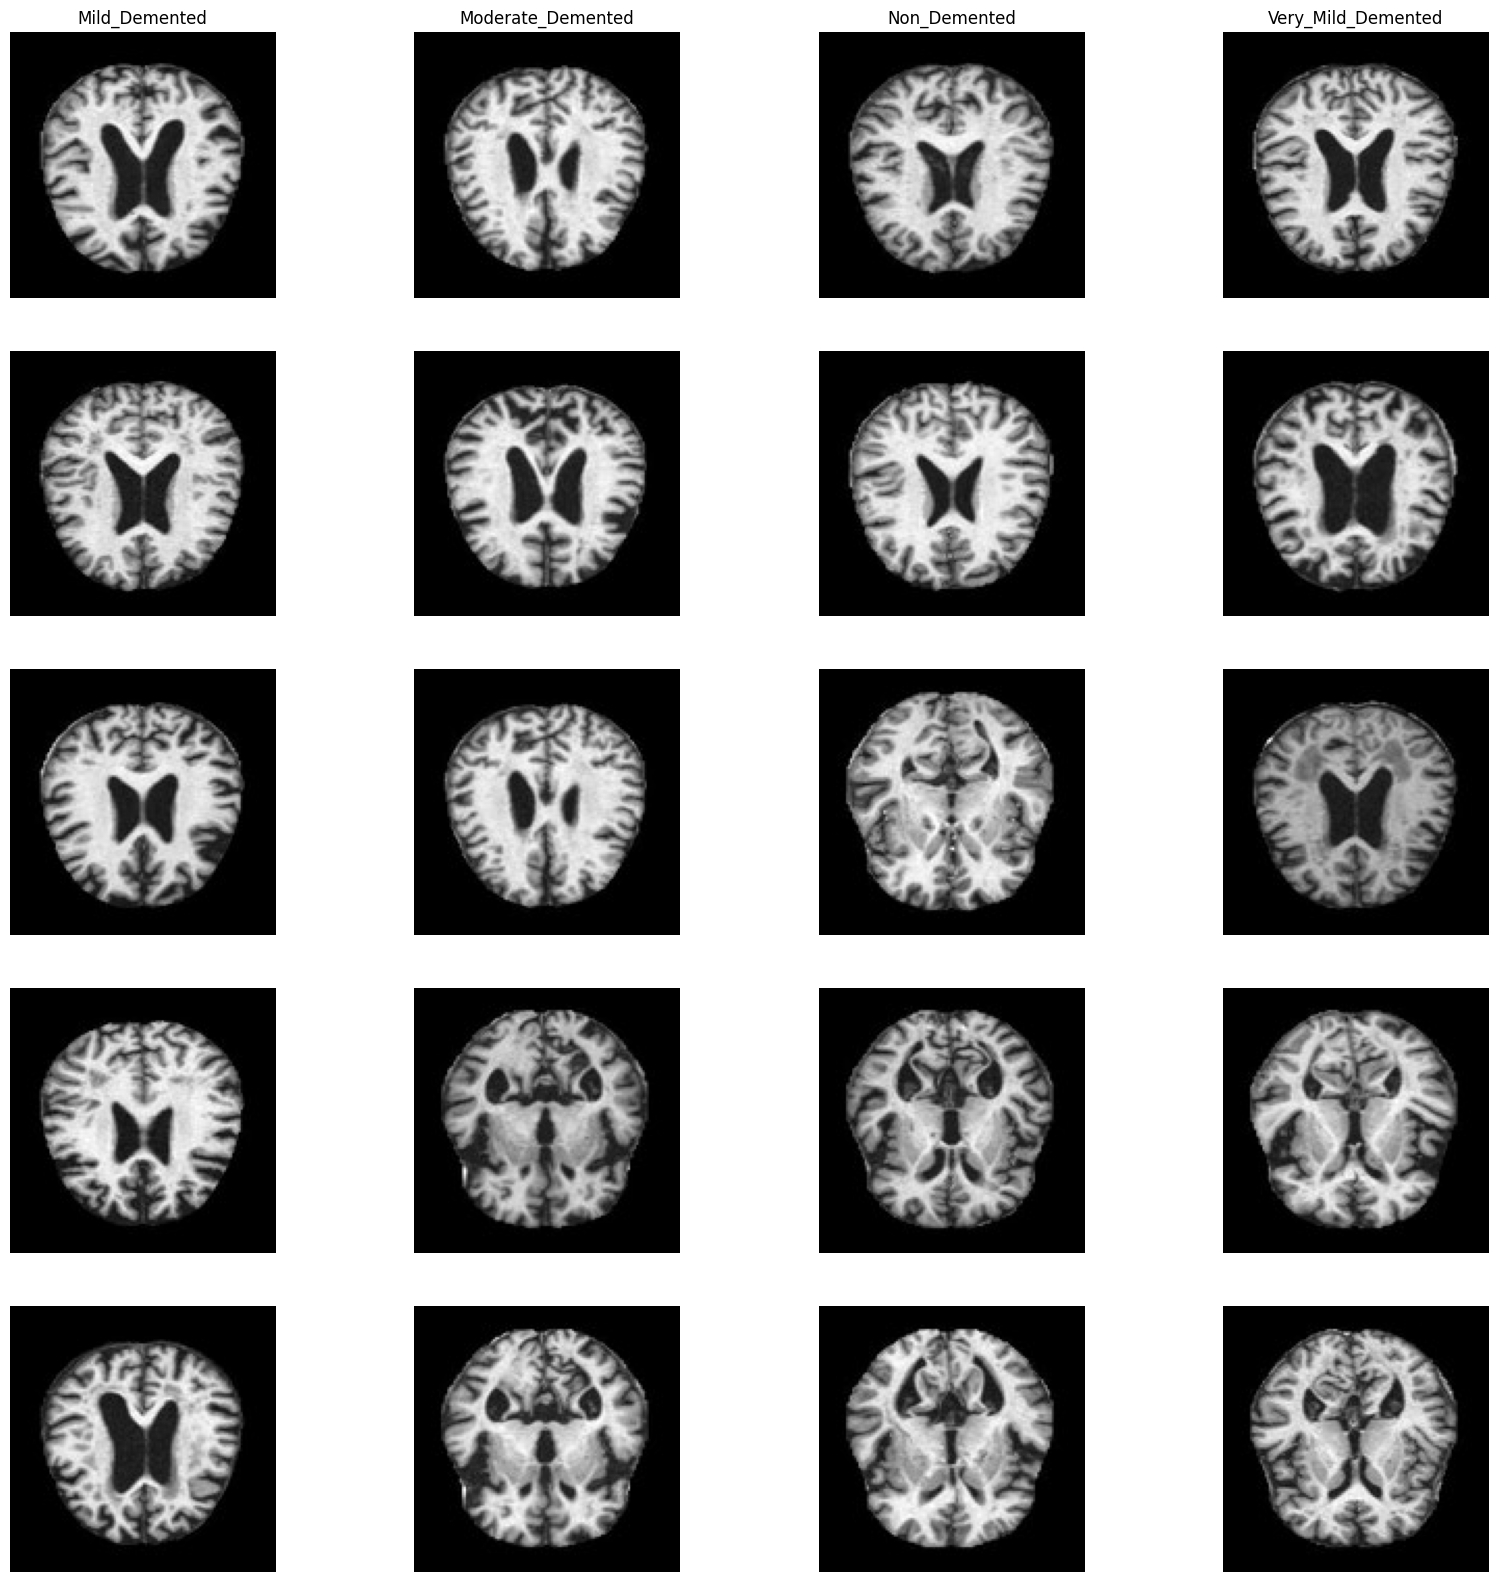

In [71]:
# let's create a dictionary where:
# - keys are folder names (-> the 8 classes)
# - values are the filenames for the files in each folder
imgs = {c: glob(join(train_path, c, "*")) for c in classes}

for key in imgs.keys():
   print("{} class has {} samples".format(key,len(imgs[key])))

nrows=5

# CHANGE--> PLOT SOME (5) IMAGES PER CLASS ! TO SEE BETTER DIFFERENCES

fig, axs = plt.subplots(nrows=nrows, ncols=len(classes), figsize=(20, 20))

for i,(c,fnames) in enumerate(imgs.items()): # i is the count, (images,labels) key and value
    axs[0,i].set_title(c)
    for n in range(nrows):
        fname=(fnames[n]).replace('\\','/')
        im= Image.open(fname)
        gray_im = im.convert('L')
        axs[n,i].imshow(gray_im, cmap='gray')
for ax in axs.flatten():
    ax.axis("off")

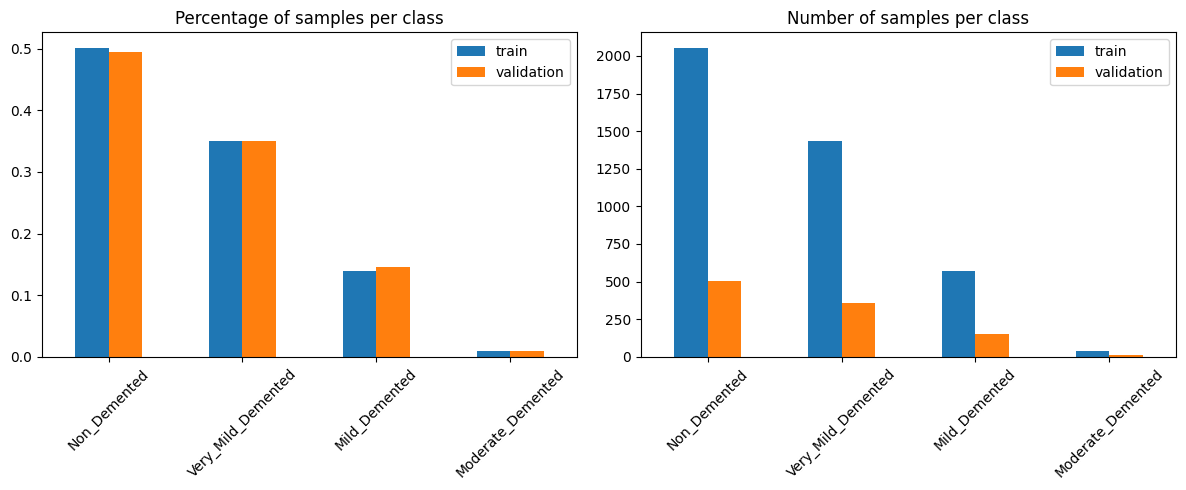

<Figure size 640x480 with 0 Axes>

In [72]:
train_labels = np.concatenate([y for _, y in train_ds], axis=0)
val_labels = np.concatenate([y for _, y in val_ds], axis=0)
train_labels = [train_ds.class_names[idx] for idx in train_labels]
val_labels = [val_ds.class_names[idx] for idx in val_labels]

fig,axs = plt.subplots(1,2,figsize=(12,5))

vis_ratio = True # if we want to plot the num of samples or the ratio of each class
vis_title = 'Percentage of samples per class' if vis_ratio else 'Number of samples per class'
df_cnt = pd.concat([pd.Series(train_labels).value_counts(normalize=vis_ratio), pd.Series(val_labels).value_counts(normalize=vis_ratio)], axis=1)
df_cnt.plot(kind='bar', ax=axs[0], title=vis_title, rot=45)
axs[0].legend(['train', 'validation'])

plt.subplot(1,2,2)
vis_ratio = False # if we want to plot the num of samples or the ratio of each class
vis_title = 'Percentage of samples per class' if vis_ratio else 'Number of samples per class'
df_cnt = pd.concat([pd.Series(train_labels).value_counts(normalize=vis_ratio), pd.Series(val_labels).value_counts(normalize=vis_ratio)], axis=1)
df_cnt.plot(kind='bar', ax=axs[1], title=vis_title, rot=45)
axs[1].legend(['train', 'validation'])

plt.tight_layout()

# Show the plot
plt.show()
plt.savefig('Dataset distribution.png')

Is possible to see how the dataset is unbalanced, is usefull to apply data aumentation in a specific manner for each class in order to prevent understimation of the minority class.

# Feature Engineering

Because we are working with categorical and noncontinuous data, we want to convert our model into one-hot encodings. One-hot encodings are a way for the model to understand that we're looking at categorial instead of continuous data. Transforming features so that they'll be more understandable is called feature engineering. Learn more about feature engineering [here](https://developers.google.com/machine-learning/crash-course/representation/feature-engineering).

In [73]:
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

The following cell makes calling images from our dataset more efficient.

In [74]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [75]:
def labels_fromPrefetch(test_ds):
    #  Function to extract labels from a Prefetch Dataset 
    # Get y_true labels
    test_ds_it=test_ds.as_numpy_iterator() #Numpy iterator
    true_labels = []  # Lista per le etichette reali

    for batch in test_ds_it:
        # Assumiamo che ogni batch contenga etichette reali e previste
        true_batch,true_batch_labels = batch  # Sostituisci con la chiave corretta
        # Aggiungere le etichette del batch alle liste
        true_labels.extend(true_batch_labels)


    # Confusion matrix
    y_true_onehot = np.vstack(true_labels)
    y_true=np.argmax(y_true_onehot,axis=1)
    return y_true

def observations_fromPrefetch(train_ds):
    iterator = iter(train_ds)
    all_tensors=[]
    while True:
        try:
            batch_x, batch_y = iterator.get_next()
            all_tensors.append((batch_x))
        except tf.errors.OutOfRangeError:
            # Fine del dataset
            break
    return all_tensors

In [76]:
## Layers for data augmentation

RandomZoom_layer1=(tf.keras.layers.RandomZoom(
    height_factor=(0.1, 0.3),
    width_factor=(0.1, 0.3),
    fill_mode="constant",
    seed=2023
))

RandomWidth_layer1=tf.keras.layers.RandomWidth(
    (-0.2,0.2), interpolation='bilinear', seed=2023) 

RandomHeight_layer1=tf.keras.layers.RandomHeight(
    (-0.2,0.2), interpolation='bilinear', seed=2023) 

RandomRotation_layer1=tf.keras.layers.RandomRotation(
    (-0.2,0.2),
    fill_mode='reflect',
    interpolation='bilinear',
    seed=2023)

RandomRotation_layer2=tf.keras.layers.RandomRotation(
    (-0.2,0.2),
    fill_mode='constant',
    interpolation='bilinear', fill_value=0.0,
    seed=2023)

RandomFlip_layer1=tf.keras.layers.RandomFlip(
    mode="horizontal_and_vertical", seed=2023)


RandomTranslation_layer1=tf.keras.layers.RandomTranslation(
    (-0.2,0.2),
     (-0.2,0.2),
    fill_mode='reflect',
    interpolation='bilinear',
    seed=2023)

RandomTranslation_layer2=tf.keras.layers.RandomTranslation(
    (-0.2,0.2),
     (-0.2,0.2),
    fill_mode='constant',
    interpolation='bilinear',
    seed=2023,fill_value=0.0)

RandomCrop_layer1=tf.keras.layers.RandomCrop(
    120,120, seed=2023)

RandomBrightness_layer1=tf.keras.layers.RandomBrightness(
    0.2, seed=2023)

RandomContrast_layer1=tf.keras.layers.RandomContrast(
    0.2 , seed=2023)
input_layer= tf.keras.Input(shape=(*IMAGE_SIZE, 3))

In [77]:
# DATA AUGMENTATION FOR BALANCING CLASSES

#Class - 1: Mild Demented (896 images)
#Class - 2: Moderate Demented (64 images)
#Class - 3: Non Demented (3200 images)
#Class - 4: Very Mild Demented (2240 images)
#EXTRACT LABELS
labels_train=labels_fromPrefetch(train_ds)   #1d array of dimension (4095)       
number_of0=np.count_nonzero(labels_train==0)  #568= Class 1 : Mild Demented--> 3,6 (=4) data aug
number_of1=np.count_nonzero(labels_train==1)  #41= Class  2: Moderate Demented (64 images)--> 50 data aug
number_of2=np.count_nonzero(labels_train==2)  #2053= Class 3: Non Demented (3200 images)--> 0 data aug
number_of3=np.count_nonzero(labels_train==3)  #1433 Class= 4: Very Mild Demented (2240 images)--> 1,43 (=1) data aug


# EXTRACT OBSERVATIONS 
tensors_train=observations_fromPrefetch(train_ds)  #list of 103 4D tensorflows tensors (40,128,128,3): 

list_of_arrays = [tensor.numpy() for tensor in tensors_train]  #list of 103 4D arrays  (40,128,128,3)
s=list_of_arrays[0].shape  # (40,128,128,3)
images_tot = [np.reshape((tensor), (-1, 128, 128, 3)) for tensor in list_of_arrays]  # 4D array (4095,128,128,3) 
images_tot = list(np.concatenate(images_tot, axis=0))  # list of 4095 3d arrays
example=images_tot[0]   #3darray (128,128,3); all values in 3rd dimension are the same --> example[i,j,1]=example[i,j,2]=example[i,j,3]

augmented_images = []
augmented_labels = []
for i in range(len(images_tot)): #len is 4095, first dimensions
    image = images_tot[i]   #nd array (128,128,3)
    label = labels_train[i]

     # Apply data augmentation selectively based on the class label
    if label == 0: #568  Class 1 : Mild Demented--> 2053/568= 3,6 (=4) data aug
        augmented_image = RandomRotation_layer1(image)  #tensor 
        augmented_image2= RandomTranslation_layer1(image)
        augmented_image3=RandomZoom_layer1(image)                                    
        augmented_images_conc = tf.keras.layers.Concatenate(axis=0)([image, augmented_image, augmented_image2, augmented_image3])            
    if label == 1: #41 Class  2: Moderate Demented --> 2053/41= 50 data aug
       augmented_image_list = [RandomRotation_layer1(image) for _ in range(10)]  #list of  50 tensors
       augmented_images_conc1= tf.concat([image] + augmented_image_list, axis=0)

       augmented_image2_list = [RandomTranslation_layer1(image) for _ in range(10)]
       augmented_images_conc2 = tf.concat([image] + augmented_image2_list, axis=0)
       augmented_images_conc2=augmented_images_conc2[128:]

       #for augmented_image in augmented_image2_list:
    
       augmented_image3_list = [RandomZoom_layer1(image)  for _ in range(10)]
       #for augmented_image in augmented_image3_list:
       augmented_images_conc3 = tf.concat([image] + augmented_image3_list, axis=0)
       augmented_images_conc3=augmented_images_conc3[128:]

       augmented_image4_list = [RandomFlip_layer1(image)  for _ in range(10)]
       #for augmented_image in augmented_image4_list:
       augmented_images_conc4 = tf.concat([image] + augmented_image4_list, axis=0)
       augmented_images_conc4=augmented_images_conc4[128:]

       augmented_image5_list = [RandomBrightness_layer1(image)  for _ in range(10)] ### I DON'T KNOW IF BRIGHTNESS WORKS!
       #for augmented_image in augmented_image5_list:
       augmented_image_conc5 = tf.concat([image] + augmented_image5_list, axis=0)
       augmented_images_conc5=augmented_image_conc5[128:]
       augmented_images_conc=tf.concat([augmented_images_conc1, augmented_images_conc2, augmented_images_conc3,augmented_images_conc4,augmented_image_conc5], axis=0)
       # ADD IMAGE!!
    if label == 2: #2053 Class 3: Non Demented --> 2053/2053=1 data aug
       augmented_image=image
       augmented_images_conc=augmented_image
        #augmented_images_conc =augmented_image
    if label == 3:  #1433 Class 4: Very Mild Demented --> 2053/1433 = 1,43 (=2) data aug
        augmented_image=RandomRotation_layer1(image)
        augmented_images_conc = tf.keras.layers.Concatenate(axis=0)([image,augmented_image]) 

    #Target Shape of tensor
    target_shape = (128, 128, 3)

    # Calculate the number of tensors to be created
    num_tensors = augmented_images_conc.shape[0] // target_shape[0]

    # Reshape the tensor into multiple tensors of shape (128, 128, 3)
    augmented_images_resh = tf.split(augmented_images_conc, num_tensors, axis=0)

    for el in augmented_images_resh:
       augmented_images.append(el)
    for i in range(len(augmented_images_resh)):
       augmented_labels.append(label)


In [62]:
#function that let us to prefetch the augmented dataset
def Prefetch_fromLO(test_labels,test_observations,batch_size=BATCH_SIZE):
    test_labels_np = np.array(test_labels)
    test_observations_np = np.array(test_observations)

    # Create a tf.data.Dataset from the list
    dataset = tf.data.Dataset.from_tensor_slices((test_observations_np,  test_labels_np))
    
    # Apply prefetching
    prefetch_dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    # Apply any additional transformations or mappings here
    # For example, if you want to one-hot encode the labels, you can use map:
    prefetch_dataset = prefetch_dataset.map(one_hot_label, num_parallel_calls=AUTOTUNE)
    prefetch_dataset= prefetch_dataset.cache().prefetch(buffer_size=AUTOTUNE)

    # Batch the dataset
    prefetch_dataset = prefetch_dataset.batch(batch_size)

    return prefetch_dataset

In [88]:
train_ds_aug=Prefetch_fromLO(augmented_labels,augmented_images)

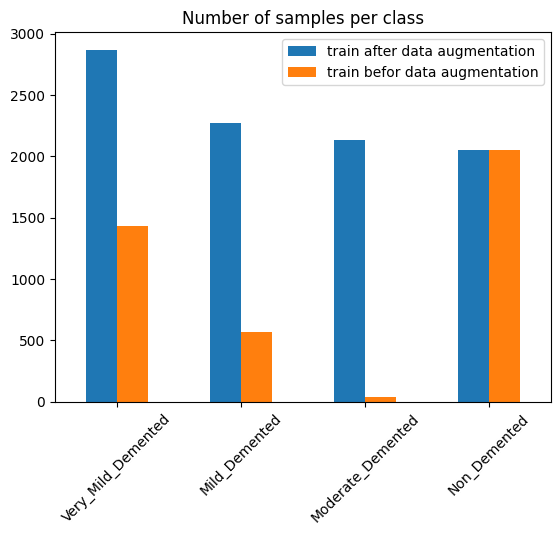

In [78]:
train_labels_names=['Mild_Demented' if el==0 else 'Moderate_Demented' if el==1 else 'Non_Demented'  if el==2 else 'Very_Mild_Demented'   for el in augmented_labels]
vis_ratio = False # if we want to plot the num of samples or the ratio of each class
vis_title = 'Percentage of samples per class' if vis_ratio else 'Number of samples per class'
df_cnt = pd.concat([pd.Series(train_labels_names).value_counts(normalize=vis_ratio), pd.Series(train_labels).value_counts(normalize=vis_ratio)], axis=1)
df_cnt.plot(kind='bar', title=vis_title, rot=45)
plt.legend(['train after data augmentation', 'train befor data augmentation'])
plt.savefig('Data augmentation results.png')

# Deciding a Metric

The most conventional metric to use is probably accuracy. Accuracy, however, cannot be used for imbalanced datasets. Let's check how many images are in each class for our training data.

Our dataset is not balanced, so we cannot use accuracy as our metric. For this tutorial, we will be using ROC AUC. Intuitively, ROC AUC gives a score, with higher scores closer to 1 indicating that the different classes can be distinguishable for the model. A lower score closer indicates that the the model cannot distinguish between different classes. A score of 0.5 indicates that the ordering the images is pretty much random. Learn more about ROC AUC [here](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc).

# Build the ML Model

We'll be using the same architecture for our model as my [Pneumonia Classification NB](https://www.kaggle.com/amyjang/tensorflow-pneumonia-classification-on-x-rays#4.-Build-the-CNN). Using `tf.keras`, we can easily build up the layers of our CNN.

In [79]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

def dense_block(units, dropout_rate, L2): # add regularization at the dense layer (dense layer has are more or less fulliconnected, is important to reguraraze weight in order to avoid overfitting)
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(L2)),
        tf.keras.layers.BatchNormalization(), #change the layer: is not practice use a batch normalization after a relu activation
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def build_model_original():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7, 0),
        dense_block(128, 0.5, 0),
        dense_block(64, 0.2, 0),
        
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model

def build_model_tunable(L2,drop_out):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(drop_out),
        
        conv_block(256),
        tf.keras.layers.Dropout(drop_out),
        
        tf.keras.layers.Flatten(),
        dense_block(512, drop_out*3, L2),
        dense_block(128, drop_out*2, L2),
        dense_block(64, drop_out, L2),
        
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model

In [ ]:
#tf.keras.utils.plot_model(model, to_file="cnn.png", show_shapes=True) #plot the network

# Training the Model

To more efficiently train our model. We will be using callbacks to adjust our learning rate and to stop our model once it converges.

The [learning rate](https://developers.google.com/machine-learning/glossary#learning-rate) is a very important hyperparameter in the model. Having a LR that is too high will prevent the model from converging. Having a LR that is too slow will make the process too long. Stopping our model early is one mechanism that prevents overfitting.

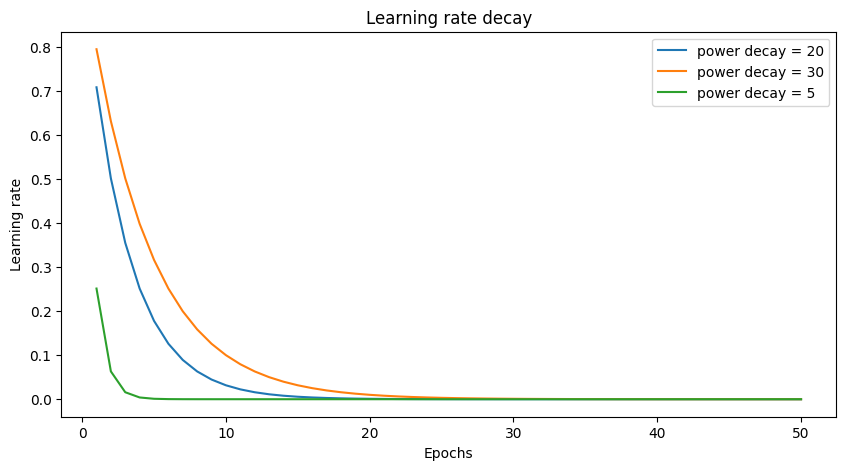

In [80]:
def exponential_decay(s):
    def exponential_decay_fn(epoch):
        return 0.001 **(epoch / s)
    return exponential_decay_fn

epochs=np.linspace(1,50,50)
lr_epochs=0.001**(epochs / 20)
lr_epochs2=0.001**(epochs/30)
lr_epochs3=0.001**(epochs / 5)

plt.figure(figsize=(10,5))
plt.plot(epochs, lr_epochs,label="power decay = 20")
plt.plot(epochs, lr_epochs2,label="power decay = 30")
plt.plot(epochs, lr_epochs3,label="power decay = 5")

plt.title("Learning rate decay")
plt.xlabel("Epochs")
plt.ylabel("Learning rate")
plt.legend()

plt.savefig('Learning_Rate_Decay.png')

Let's fit our model!

In [81]:
# ORIGINAL MODEL WITH ORIGINAL DATA
model_name = 'Original_model.h5'
EPOCHS = 100

with strategy.scope():
    model = build_model_original()

    METRICS = [tf.keras.metrics.AUC(name='auc')]
        
    model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

exponential_decay_fn = exponential_decay(20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(model_name,save_best_only=True)         
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)

history_original = model.fit(        #for each epochs the data are shuffled and a portion is used as valid test
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    verbose = 1, #progression bar
    epochs=EPOCHS
)

Epoch 1/100
256/256 [==============================] - ETA: 0s - loss: 19.4999 - auc: 0.6184

C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


256/256 [==============================] - 79s 287ms/step - loss: 19.4999 - auc: 0.6184 - val_loss: 2926531928129536.0000 - val_auc: 0.4682 - lr: 1.0000
Epoch 2/100
256/256 [==============================] - 74s 290ms/step - loss: 4.9106 - auc: 0.6729 - val_loss: 2.0376 - val_auc: 0.7217 - lr: 0.7079
Epoch 3/100
256/256 [==============================] - 72s 281ms/step - loss: 1.5422 - auc: 0.7428 - val_loss: 1.3765 - val_auc: 0.7445 - lr: 0.5012
Epoch 4/100
256/256 [==============================] - 72s 283ms/step - loss: 1.2469 - auc: 0.7508 - val_loss: 1.1468 - val_auc: 0.7937 - lr: 0.3548
Epoch 5/100
256/256 [==============================] - 73s 285ms/step - loss: 1.1095 - auc: 0.7693 - val_loss: 1.0635 - val_auc: 0.7917 - lr: 0.2512
Epoch 6/100
256/256 [==============================] - 72s 281ms/step - loss: 1.0631 - auc: 0.7788 - val_loss: 1.0613 - val_auc: 0.8085 - lr: 0.1778
Epoch 7/100
256/256 [==============================] - 70s 275ms/step - loss: 1.0468 - auc: 0.7826 - v

In [89]:
# ORIGINAL MODEL WITH AUGMENTED DATA
model_name = 'Original_model_augmented_data.h5'
EPOCHS = 100

with strategy.scope():
    model = build_model_original()

    METRICS = [tf.keras.metrics.AUC(name='auc')]
        
    model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

exponential_decay_fn = exponential_decay(20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(model_name,save_best_only=True)         
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)

history_original_AUG = model.fit(        #for each epochs the data are shuffled and a portion is used as valid test
    train_ds_aug,
    batch_size = BATCH_SIZE,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    verbose = 1, #progression bar
    epochs=EPOCHS
)

Epoch 1/100
583/583 [==============================] - ETA: 0s - loss: 68.2111 - auc: 0.5513

C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


583/583 [==============================] - 185s 305ms/step - loss: 68.2111 - auc: 0.5513 - val_loss: 787741312.0000 - val_auc: 0.4323 - lr: 1.0000
Epoch 2/100
583/583 [==============================] - 156s 267ms/step - loss: 7.6516 - auc: 0.5671 - val_loss: 3.6493 - val_auc: 0.6946 - lr: 0.7079
Epoch 3/100
583/583 [==============================] - 160s 275ms/step - loss: 5.5240 - auc: 0.5721 - val_loss: 2.1260 - val_auc: 0.5714 - lr: 0.5012
Epoch 4/100
583/583 [==============================] - 157s 270ms/step - loss: 2.0669 - auc: 0.6193 - val_loss: 20126960.0000 - val_auc: 0.6666 - lr: 0.3548
Epoch 5/100
583/583 [==============================] - 157s 268ms/step - loss: 1.7904 - auc: 0.6230 - val_loss: 1.3136 - val_auc: 0.6265 - lr: 0.2512
Epoch 6/100
583/583 [==============================] - 160s 274ms/step - loss: 1.7270 - auc: 0.6330 - val_loss: 1.4511 - val_auc: 0.6482 - lr: 0.1778
Epoch 7/100
583/583 [==============================] - 155s 266ms/step - loss: 1.6778 - auc: 0.6

In [95]:
#Hyperparameter tuning with augmented data
'''
drop_out = [0.1, 0.2, 0.3]
s = [5, 20, 30]
L2 = [1e-4, 1e-3, 1e-2]
'''
drop_out = [0.1]
s = [20]
L2 = [1e-3]

EPOCHS = 40

hparam = {
    'drop_out' : drop_out,
    's' : s,
    'L2' : L2
}

hparam_grid = ParameterGrid(hparam)

history = dict()

for p in hparam_grid:
    drop_out = p['drop_out']
    s = p['s']
    L2 = p['L2']

    model_name = 's_'+str(s)+'_L2_'+str(L2)+'_dropOut_'+str(drop_out)+'.h5'

    with strategy.scope():
        model = build_model_tunable(L2,drop_out)

        METRICS = [tf.keras.metrics.AUC(name='auc')]
        
        model.compile(
            optimizer='adam',
            loss=tf.losses.CategoricalCrossentropy(),
            metrics=METRICS
        )

    exponential_decay_fn = exponential_decay(s)

    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(model_name,save_best_only=True)         
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5, restore_best_weights=True)

    history[model_name] = model.fit(        #for each epochs the data are shuffled and a portion is used as valid test
        train_ds_aug,
        batch_size = BATCH_SIZE,
        validation_data=val_ds,
        callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
        verbose = 1, #progression bar
        epochs=EPOCHS
    )
    

Epoch 1/40
583/583 [==============================] - ETA: 0s - loss: 2500.0950 - auc: 0.5684

C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


583/583 [==============================] - 177s 295ms/step - loss: 2500.0950 - auc: 0.5684 - val_loss: 928.0468 - val_auc: 0.3276 - lr: 1.0000
Epoch 2/40
583/583 [==============================] - 178s 305ms/step - loss: 437.1703 - auc: 0.5827 - val_loss: 581.3809 - val_auc: 0.6711 - lr: 0.7079
Epoch 3/40
583/583 [==============================] - 175s 300ms/step - loss: 274.1977 - auc: 0.5815 - val_loss: 2649.1985 - val_auc: 0.4304 - lr: 0.5012
Epoch 4/40
583/583 [==============================] - 183s 315ms/step - loss: 125.7027 - auc: 0.6027 - val_loss: 160.8710 - val_auc: 0.5123 - lr: 0.3548
Epoch 5/40
583/583 [==============================] - 174s 299ms/step - loss: 111.7161 - auc: 0.6218 - val_loss: 32.9438 - val_auc: 0.6452 - lr: 0.2512
Epoch 6/40
583/583 [==============================] - 175s 300ms/step - loss: 45.6176 - auc: 0.6403 - val_loss: 2877.9402 - val_auc: 0.5666 - lr: 0.1778
Epoch 7/40
583/583 [==============================] - 176s 301ms/step - loss: 33.5031 - auc:

# Visualize Model Metrics

Let's graph the ROC AUC metric and loss after each epoch for the training and validation data. Although we didn't use a random seed for our notebook, the results may slightly vary, generally the scores for the validataion data is similar, if not better, than the training dataset.

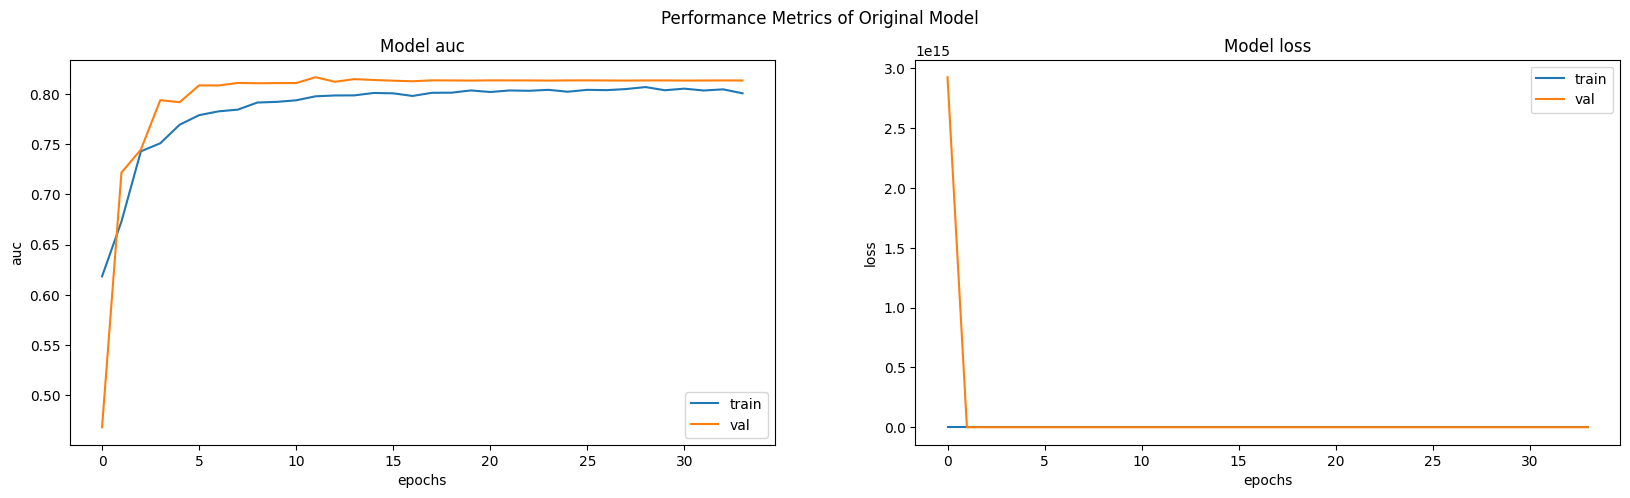

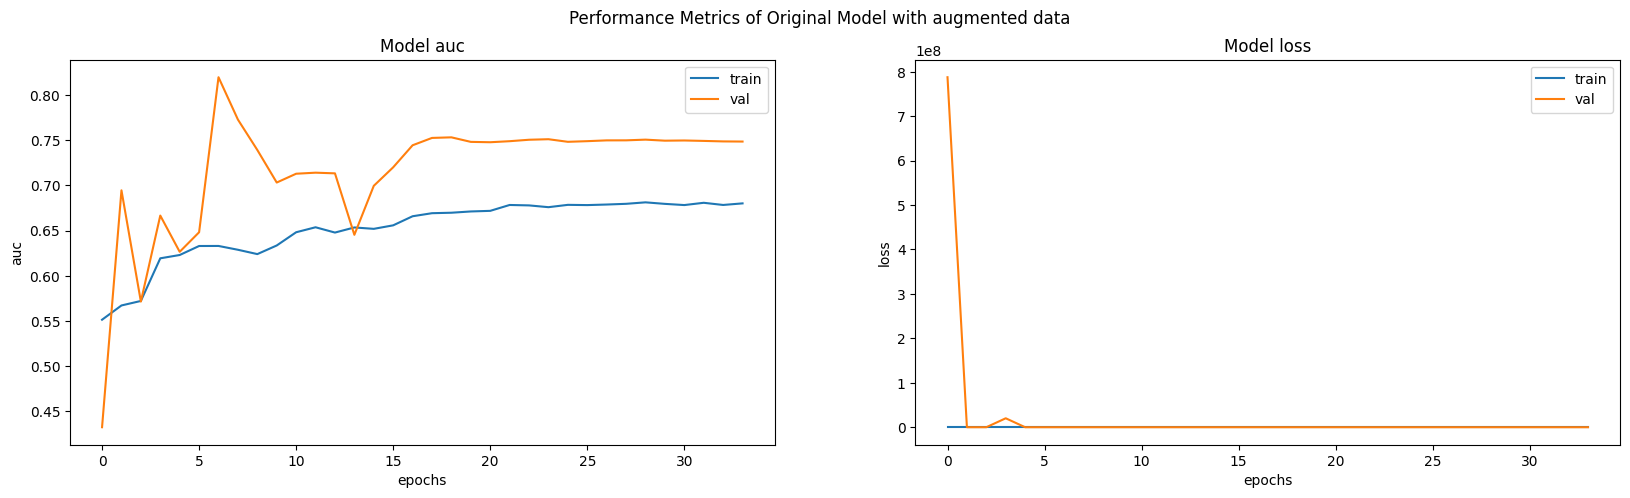

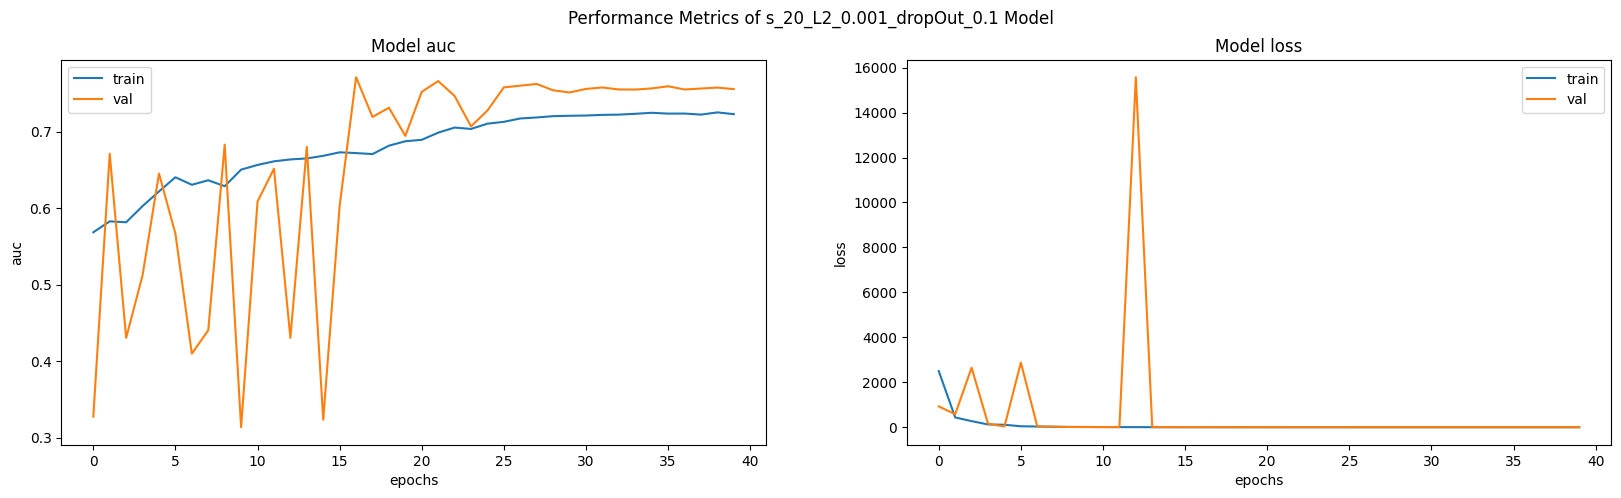

In [96]:
# Original model
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history_original.history[met])
    ax[i].plot(history_original.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

plt.suptitle('Performance Metrics of Original Model')

plt.savefig('Original_model.png')

# Original model AUGMENTED DATA
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history_original_AUG.history[met])
    ax[i].plot(history_original_AUG.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

plt.suptitle('Performance Metrics of Original Model with augmented data')

plt.savefig('Original_model_AUG.png')


#tunable models with augmanted dataset
for k in history.keys():
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    ax = ax.ravel()
    for i, met in enumerate(['auc', 'loss']):
        ax[i].plot(history[k].history[met])
        ax[i].plot(history[k].history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])
    
    plt.suptitle('Performance Metrics of '+k[:-3]+' Model')

    plt.savefig(k[:-3]+'.png')

# Evaluate the Model

Although we used the validatation dataset to continually evaluate the model, we also have a separate testing dataset. Let's prepare the testing dataset.

In [85]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset/test",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1281 files belonging to 4 classes.


In [39]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	#This function plot confusion matrix method from sklearn package.
	

	plt.figure(figsize= (12, 12))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)

	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

	plt.savefig(title+'.png')
	

81/81 [==============================] - 6s 68ms/step
Test Loss:  0.9899921417236328
Test Accuracy:  0.8070577383041382
Confusion Matrix, Without Normalization
[[  0   0 118  62]
 [  0   0  11   2]
 [  0   0 538 102]
 [  0   0 341 107]]


C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1

                    precision    recall  f1-score   support

     Mild_Demented       0.00      0.00      0.00       180
 Moderate_Demented       0.00      0.00      0.00        13
      Non_Demented       0.53      0.84      0.65       640
Very_Mild_Demented       0.39      0.24      0.30       448

          accuracy                           0.50      1281
         macro avg       0.23      0.27      0.24      1281
      weighted avg       0.40      0.50      0.43      1281

81/81 [==============================] - 5s 59ms/step
Test Loss:  0.9775877594947815
Test Accuracy:  0.8161680698394775
Confusion Matrix, Without Normalization
[[ 53   0  58  69]
 [  3   0   8   2]
 [ 45   0 504  91]
 [ 59   0 256 133]]


C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1

                    precision    recall  f1-score   support

     Mild_Demented       0.33      0.29      0.31       180
 Moderate_Demented       0.00      0.00      0.00        13
      Non_Demented       0.61      0.79      0.69       640
Very_Mild_Demented       0.45      0.30      0.36       448

          accuracy                           0.54      1281
         macro avg       0.35      0.34      0.34      1281
      weighted avg       0.51      0.54      0.51      1281



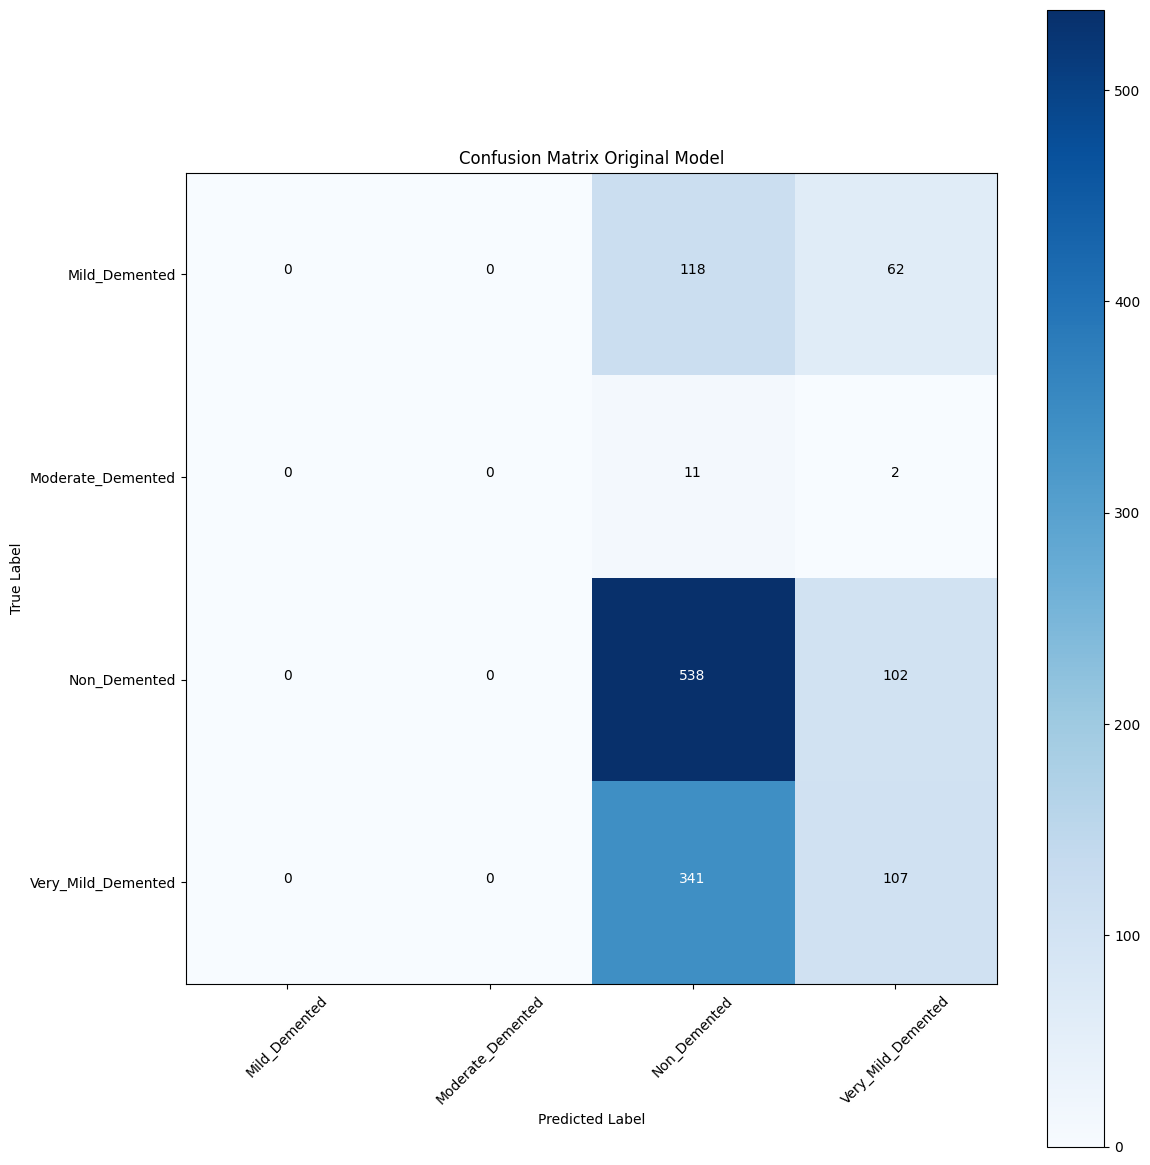

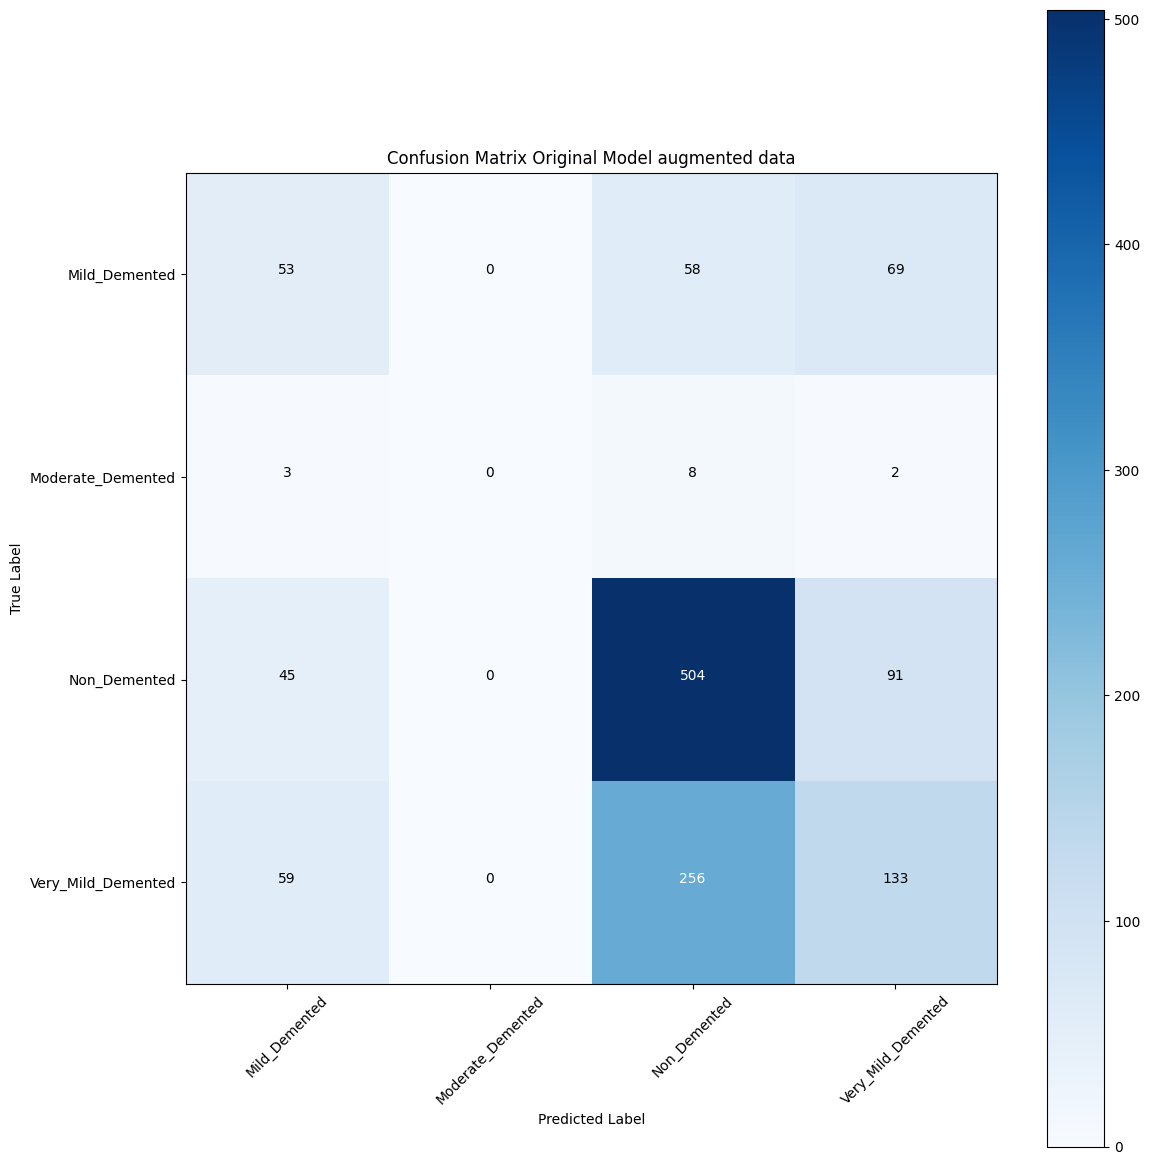

In [93]:
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import itertools

y_true=labels_fromPrefetch(test_ds)

model = load_model('Original_model.h5')
test_score = model.evaluate(test_ds)
test_pred = model.predict(test_ds)
y_pred = np.argmax(test_pred, axis=1) #prediction to class labels
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

cm= confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix Original Model')
print(classification_report(y_true, y_pred, target_names= classes))

model = load_model('Original_model_augmented_data.h5')
test_score = model.evaluate(test_ds)
test_pred = model.predict(test_ds)
y_pred = np.argmax(test_pred, axis=1) #prediction to class labels
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

cm= confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix Original Model augmented data')
print(classification_report(y_true, y_pred, target_names= classes))


81/81 [==============================] - 5s 56ms/step
Test Loss:  2.578023910522461
Test Accuracy:  0.7540820837020874
Confusion Matrix, Without Normalization
[[  7   0  15 158]
 [  0   0   5   8]
 [  5   0 359 276]
 [ 18   0 138 292]]


C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Utente\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1

                    precision    recall  f1-score   support

     Mild_Demented       0.23      0.04      0.07       180
 Moderate_Demented       0.00      0.00      0.00        13
      Non_Demented       0.69      0.56      0.62       640
Very_Mild_Demented       0.40      0.65      0.49       448

          accuracy                           0.51      1281
         macro avg       0.33      0.31      0.30      1281
      weighted avg       0.52      0.51      0.49      1281



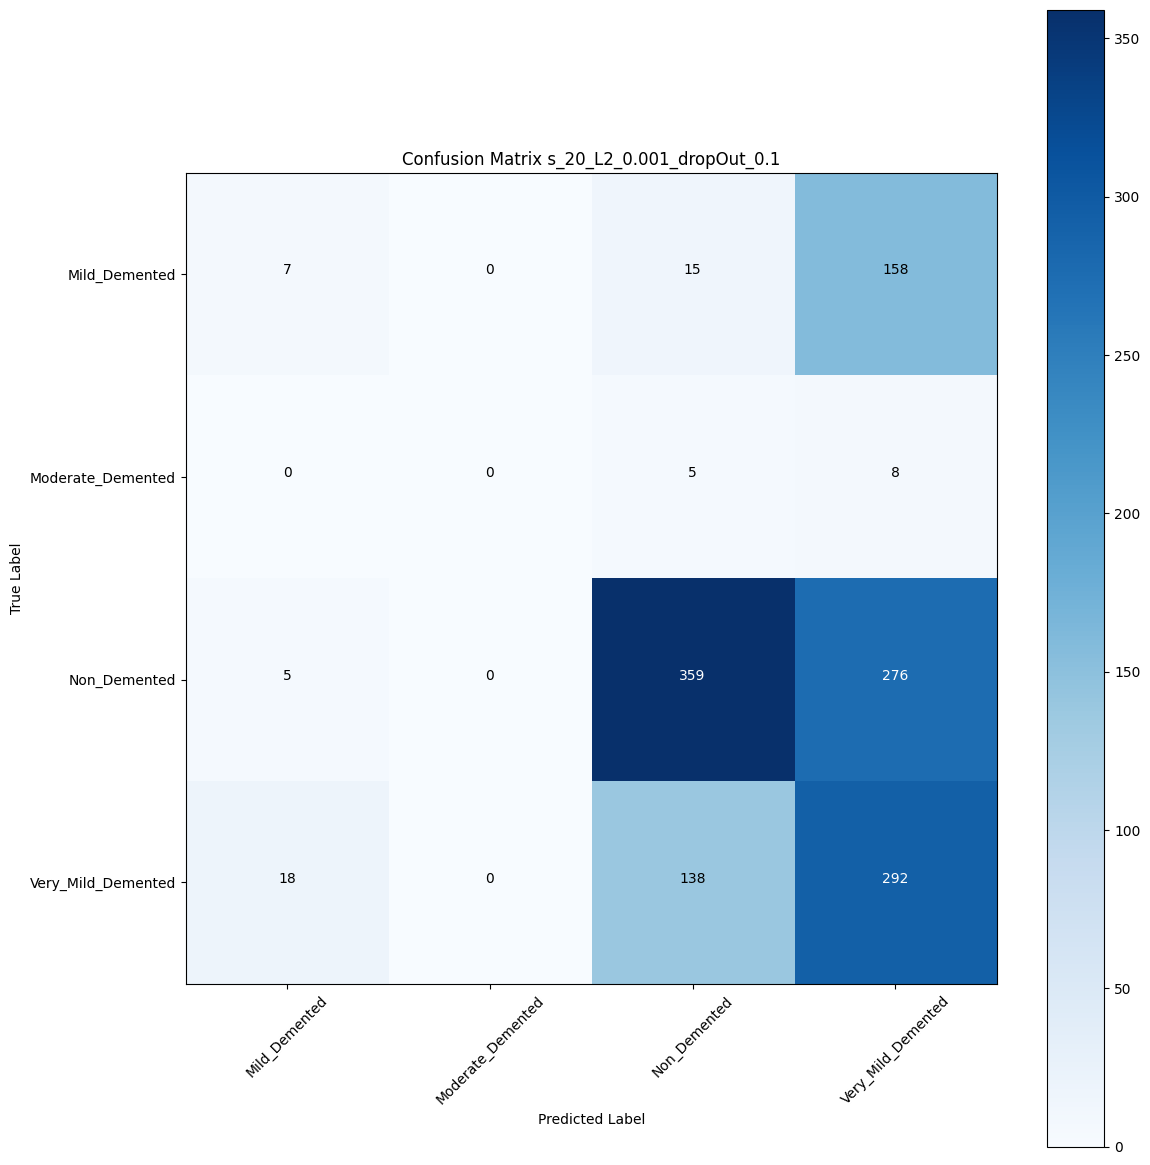

In [97]:
for k in history.keys():
    model = load_model(k)
    test_score = model.evaluate(test_ds)
    test_pred = model.predict(test_ds)
    y_pred = np.argmax(test_pred, axis=1) #prediction to class labels
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])

    cm= confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix '+k[:-3])
    print(classification_report(y_true, y_pred, target_names= classes))
    